In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load pre-saved datasets
train_df_save_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/data/train_df.csv"
test_df_save_path = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/data/test_df.csv"

train_df = pd.read_csv(train_df_save_path)
test_df = pd.read_csv(test_df_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 3: Model Architecture 
1. The App crashed with max length 128, which was the suggested length. Reducing it to 32 might affect the accuracy

2. Tokenizer:

    Uses BertTokenizer to tokenize and encode the dataset.
    Uses batch_encode_plus with padding, truncation, and max length = 32.
    Returns tokenized outputs in TensorFlow tensor format (return_tensors='tf'). The batch size is automatically decided during processing

3. Data Processing:

    Splits test data into validation (x_val, y_val) and test (x_test, y_test) using train_test_split with 50% for test set.
    Stratified sampling ensures the split maintains the same class distribution as the original dataset.

4. Model (TFBertForSequenceClassification):

    Uses bert-base-uncased, which is a full BERT model, unlike DistilBERT.


In [ ]:

from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.model_selection import train_test_split

# compared with older model
train_reviews = train_df['Cleaned_sentence']
train_targets = train_df['sentiment']
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5,
                                                    stratify = test_targets)
max_len= 32
# Tokenize and encode the sentences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

X_train_encoded = tokenizer.batch_encode_plus(train_reviews.tolist(), # Convert train_reviews into a Python list, containing all the text samples in the training dataset
                                              padding=True, # Pad shorter texts to the max_length to ensure all sequences in the batch are of the same length 
                                              truncation=True,  # Truncate longer texts to the max_length to prevent them from exceeding the model's input limit
                                              max_length = max_len,  # Set the maximum sequence length for each input. Sequences longer than this will be truncated, shorter ones will be padded
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

k = 0
print('Training Comments -->>',train_reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',train_targets[k])

Step 4: Results and Analysis
1. The CPU could not load 3 models at the same time, so we needed to proceed loading and evaluating models seperately.
2. The max load for test dataset was 20%. Processing over 22% would crash CPU.
3. It only returned 3 models before google collab was disconnected. The accuracy was just 50% and the inference time ranged between 675 to 685 secs.

Epoch 1, 2, 3

    Accuracy: 0.50
    Confusion Matrix:
        True Negatives (0 correctly predicted as 0): 0
        False Positives (0 incorrectly predicted as 1): 2,500
        False Negatives (1 incorrectly predicted as 0): 0
        True Positives (1 correctly predicted as 1): 2,500

This model training is failing to classify negative reviews. It seems requring more computing resources and complicated fine tuning to improve the model.

Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
CPU cores available: 2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TensorFlow Inference Time: 680.37 sec
TensorFlow Model Accuracy: 0.5000
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2500
           1     0.5000    1.0000    0.6667      2500

    accuracy                         0.5000      5000
   macro avg     0.2500    0.5000    0.3333      5000
weighted avg     0.2500    0.5000    0.3333      5000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


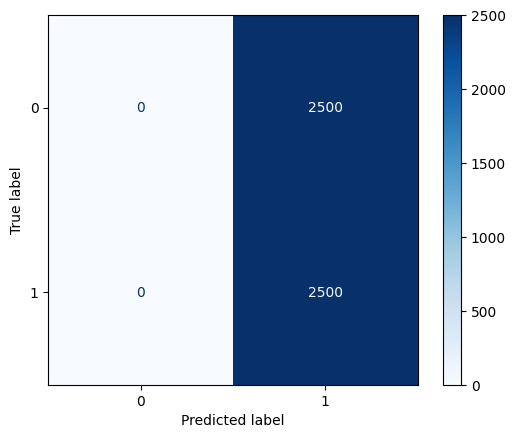

TensorFlow Inference Time: 685.22 sec
TensorFlow Model Accuracy: 0.5000
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2500
           1     0.5000    1.0000    0.6667      2500

    accuracy                         0.5000      5000
   macro avg     0.2500    0.5000    0.3333      5000
weighted avg     0.2500    0.5000    0.3333      5000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


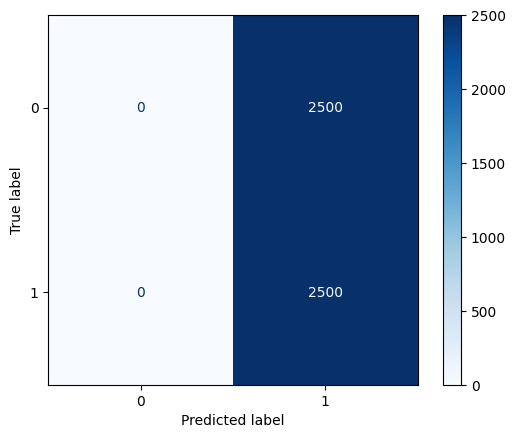

TensorFlow Inference Time: 675.53 sec
TensorFlow Model Accuracy: 0.5000
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2500
           1     0.5000    1.0000    0.6667      2500

    accuracy                         0.5000      5000
   macro avg     0.2500    0.5000    0.3333      5000
weighted avg     0.2500    0.5000    0.3333      5000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


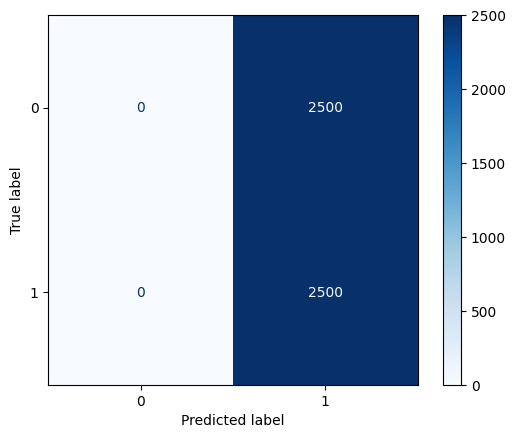


Performance Results:
tensorflow_accuracy_1: 0.5
inference_time_1: 680.3734362125397
tensorflow_accuracy_2: 0.5
inference_time_2: 685.217205286026
tensorflow_accuracy_3: 0.5
inference_time_3: 675.5313105583191


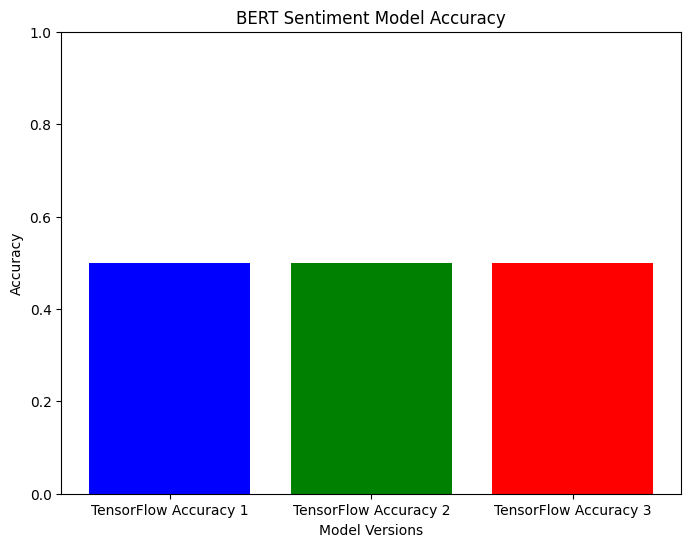

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
import time
from transformers import AutoTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# CPU Info
# !lscpu | grep 'Model name'
# !lscpu | grep 'MHz'
print("CPU cores available:", multiprocessing.cpu_count())

MODEL_NAME = "bert-base-uncased"

# Split test dataset
first_10_percent = test_df.iloc[:int(0.1 * len(test_df))]
last_10_percent = test_df.iloc[int(0.9 * len(test_df)):]  # crashed at 22%
selected_data = pd.concat([first_10_percent, last_10_percent])
test_reviews = selected_data['Cleaned_sentence'].tolist()
test_targets = selected_data['sentiment'].tolist()
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME)


def load_tensorflow_model(model, model_path):
    """
    Loads the pre-trained weights into the TensorFlow model.

    Args:
        model (tf.keras.Model): The TensorFlow model to load weights into.
        model_path (str): Path to the saved model weights.

    Returns:
        tf.keras.Model: The model with the loaded weights.
    """
    model.load_weights(model_path)
    return model

def evaluate_tensorflow(model, test_reviews, test_targets):
    """
    Evaluates the TensorFlow model on test data.

    Args:
        model (tf.keras.Model): The trained TensorFlow model.
        test_reviews (list of str): List of text samples to evaluate.
        test_targets (list): The ground truth labels for the test samples.

    Returns:
        predictions (numpy.ndarray): The predicted labels for the test data.
        test_targets_np (numpy.ndarray): The ground truth labels as a NumPy array.
    """
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    start_time = time.time()
    # Tokenize input
    inputs = tokenizer(test_reviews, padding=True, truncation=True, max_length=32, return_tensors="tf")

    # Get model predictions with the token IDs (input to the model), the attention mask (for padding tokens)
    outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], training=False) # Set training=False, since we are only evaluating

    end_time = time.time()

    # Convert logits to probabilities
    probs = tf.nn.softmax(outputs.logits, axis=1)

    # Get predicted class labels
    predictions = tf.argmax(probs, axis=1).numpy()

    # Ensure labels are integers
    test_targets_np = np.array(test_targets, dtype=int)

    # Compute accuracy
    accuracy = np.mean(predictions == test_targets_np)

    inference_time = end_time - start_time

    print(f"TensorFlow Inference Time: {inference_time:.2f} sec")
    print(f"TensorFlow Model Accuracy: {accuracy:.4f}")

    # Compute Precision, Recall, F1-score
    report = classification_report(test_targets_np, predictions, digits=4)
    print("Classification Report:\n", report)

    cm = confusion_matrix(test_targets_np, predictions)  # Fixed confusion matrix calculation
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.show()

    return accuracy, inference_time

# Load trained TensorFlow model
tensorflow_model_path_1 = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/old/epoch_1/tf_model.h5"
tensorflow_model_path_2 = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/old/epoch_2/tf_model.h5"
tensorflow_model_path_3 = "/content/drive/MyDrive/Colab Notebooks/deep_learning_movie_review/old/epoch_3/tf_model.h5"

tensorflow_model_1 = load_tensorflow_model(model, tensorflow_model_path_1)
tensorflow_accuracy_1, inference_time_1 = evaluate_tensorflow(tensorflow_model_1, test_reviews, test_targets)

tensorflow_model_2 = load_tensorflow_model(model, tensorflow_model_path_2)
tensorflow_accuracy_2, inference_time_2 = evaluate_tensorflow(tensorflow_model_2, test_reviews, test_targets)

tensorflow_model_3 = load_tensorflow_model(model, tensorflow_model_path_3)
tensorflow_accuracy_3, inference_time_3 = evaluate_tensorflow(tensorflow_model_3, test_reviews, test_targets)

# Performance Dictionary (Fixed Key Names)
performance_results = {
    "tensorflow_accuracy_1": tensorflow_accuracy_1,
    "inference_time_1": inference_time_1,
    "tensorflow_accuracy_2": tensorflow_accuracy_2,
    "inference_time_2": inference_time_2,
    "tensorflow_accuracy_3": tensorflow_accuracy_3,
    "inference_time_3": inference_time_3
}

# Print Performance Results (Fixed Syntax)
print("\nPerformance Results:")
for key, value in performance_results.items():
    print(f"{key}: {value}")

# Plot Accuracy Comparison
labels = ["TensorFlow Accuracy 1", "TensorFlow Accuracy 2", "TensorFlow Accuracy 3"]
accuracies = [tensorflow_accuracy_1, tensorflow_accuracy_2, tensorflow_accuracy_3]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel("Model Versions")
plt.ylabel("Accuracy")
plt.title("BERT Sentiment Model Accuracy")
plt.show()
